##  Основы анализа данных с pandas+sklearn
https://habr.com/post/202090/

Суть задачи: с помощью методов машинного обучения построить модель,
которая прогнозировала бы спасется человек или нет.
К задаче прилагаются 2 файла:
- `train.csv` — набор данных на основании которого будет строиться модель (обучающая выборка)
- `test.csv` — набор данных для проверки модели

Для анализа понадобятся модули Pandas и scikit-learn.
С помощью Pandas мы проведем начальный анализ данных,
а sklearn поможет в вычислении прогнозной модели.

In [1]:
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
data = pd.read_csv('train.csv')
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


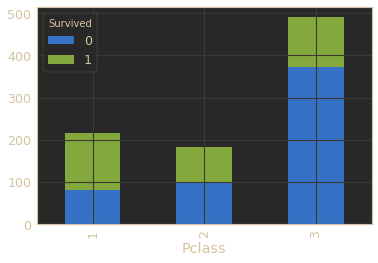

In [3]:
pivot = data.pivot_table(values='PassengerId', index='Pclass', columns='Survived', aggfunc='count')
pivot.plot(kind='bar', stacked=True)

Можно предположить, что чем выше социальный статус, тем больше вероятность спасения. Давайте проверим это взглянув на количество спасшихся и утонувших в зависимости в разрезе классов. Для этого нужно построить следующую сводную:

Пояснения по некоторым полям:
- `PassengerId` — идентификатор пассажира
- `Survived` — спасся человек (`1`) или нет (`0`)
- `Pclass` — социально-экономический статус: высокий, средний, низкий
- `Name` — имя пассажира
- `Sex` — пол пассажира
- `Age` — возраст
- `SibSp` — количество родственников 2-го порядка (муж, жена, братья, сетры)
- `Parch` — количество родственников на борту 1-го порядка (мать, отец, дети)
- `Ticket` — номер билета
- `Fare` — цена билета
- `Cabin` — каюта
- `Embarked` — порт посадки: `C` — Cherbourg, `Q` — Queenstown, `S` — Southampton

In [4]:
pivot

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [5]:
pivot[1] - pivot[0]

Pclass
1     56
2    -10
3   -253
dtype: int64

Теперь давайте взглянем, как количество родственников влияет на факт спасения:

In [6]:
pivot1 = data.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count')
pivot1

Survived,0,1
SibSp,,
0,398.0,210.0
1,97.0,112.0
2,15.0,13.0
3,12.0,4.0
4,15.0,3.0
5,5.0,NaN
8,7.0,NaN


In [7]:
pivot2 = data.pivot_table('PassengerId', ['Parch'], 'Survived', 'count')
pivot2

Survived,0,1
Parch,,
0,445.0,233.0
1,53.0,65.0
2,40.0,40.0
3,2.0,3.0
4,4.0,NaN
5,4.0,1.0
6,1.0,NaN


Как видно из графиков наше предположение снова подтвердилось, и из людей имеющих больше 1 родственников спаслись не многие.

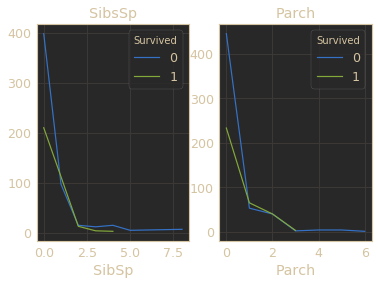

In [8]:
fig, axes = plt.subplots(ncols=2)
pivot1.plot(ax=axes[0], title='SibsSp')
pivot2.plot(ax=axes[1], title='Parch')

Сейчас порассуждаем на предмет данных, которые находятся номера кают. Теоретически данных о каютах пользователей может не быть, так что давайте посмотрим на столько это поле заполнено:

In [9]:
data.PassengerId[data.Cabin.isnull()].count(),\
data.PassengerId[data.Cabin.notnull()].count()

(687, 204)

В итоге заполнено всего 204 записи и 890, на основании этого можно сделать вывод, что данное поле при анализе можно опустить.

Следующее поле, которое мы разберем будет поле с возрастом (Age). Посмотрим на сколько оно заполнено:

In [10]:
data.PassengerId[data.Age.isnull()].count(),\
data.PassengerId[data.Age.notnull()].count()

(177, 714)

Данное поле практически все заполнено (714 непустых записей), но есть пустые значения, которые не определены. Давайте зададим ему значение равное медиане по возрасту из всей выборки.

In [11]:
saved = data.Age.copy()
data.Age.median()

28.0

In [12]:
saved.sort_values().unique()

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  ,
       14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 20.5 ,
       21.  , 22.  , 23.  , 23.5 , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 30.5 , 31.  , 32.  , 32.5 , 33.  ,
       34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  ,
       48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  , 55.5 ,
       56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 63.  , 64.  ,
       65.  , 66.  , 70.  , 70.5 , 71.  , 74.  , 80.  ,   nan])

In [13]:
data.loc[data.Age.isnull(), 'Age'] = data.Age.median()

In [14]:
data.Age.unique()

array([22.  , 38.  , 26.  , 35.  , 28.  , 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  ,  8.  ,
       19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  , 49.  ,
       29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  , 16.  ,
       25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  , 71.  ,
       37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  ,
       55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  , 45.5 ,
       20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  ,
       10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  , 70.  ,
       24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

Давайте посмотрим на поле Embarked, в котором находится порт посадки и проверим есть ли такие пассажиры у которых порт не указан:

In [15]:
data[data.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Давайте присвоим эти пассажирам порт в котором село больше всего людей:

In [16]:
data.groupby('Embarked').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
Embarked,,,,,,,,,,,
C,168,168,168,168,168,168,168,168,168,168,69
Q,77,77,77,77,77,77,77,77,77,77,4
S,644,644,644,644,644,644,644,644,644,644,129


In [17]:
embarked2passnum = data.groupby('Embarked').count().PassengerId
embarked2passnum

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [18]:
max_embarked = embarked2passnum[embarked2passnum == embarked2passnum.max()]
max_embarked

Embarked
S    644
Name: PassengerId, dtype: int64

In [19]:
max_embarked.index

Index(['S'], dtype='object', name='Embarked')

In [20]:
embarked2passnum.index[0]

'C'

In [21]:
data.Embarked[data.Embarked.isnull()]

61     NaN
829    NaN
Name: Embarked, dtype: object

In [22]:
data.loc[[61,829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [23]:
data.loc[data.Embarked.isnull(),'Embarked'] = max_embarked.index[0]

In [24]:
data.loc[[61,829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


Нам нужна цена(Fare), т.к. она определяет ранжирование внутри классов Pclass.
Например, люди внутри среднего класса могут быть разделены на тех, кто ближе к первому(высшему) классу, а кто к третьему(низший).
Проверим это поле на пустые значения и если таковые имеются заменим цену медианой по цене из все выборки:

In [25]:
data[data.Fare.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


В нашем случае пустых записей нет.

В свою очередь номер билета и имя пассажира нам никак не помогут, т. к. это просто справочная информация. Единственное для чего они могут пригодиться — это определение кто из пассажиров потенциально являются родственниками, но так как люди у которых есть родственники практически не спаслись (это было показано выше) можно пренебречь этими данными.

In [26]:
data = data.drop('PassengerId Name Ticket Cabin'.split(), axis=1)

Теперь, после удаления всех ненужных полей, наш набор выглядит так:

In [27]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Предварительная обработка входных данных

Предварительный анализ данных завершен, и получилась некая выборка.
**НО** перед тем, как строить модель, нужно закодировать все наши текстовые значения.
Можно это сделать в ручную, а можно с помощью модуля [sklearn.preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing).
Закодировать список с фиксированными значениями можно с помощью объекта [LabelEncoder()](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder).
На вход функцтт подается список значений, который надо закодировать, на выходе получается список классов индексы которого и являются кодами элементов списка.

In [28]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dicts = {}

In [29]:
data.Sex.head(4)

0      male
1    female
2    female
3    female
Name: Sex, dtype: object

In [30]:
label.fit(data.Sex).classes_

array(['female', 'male'], dtype=object)

In [31]:
label.transform(data.Sex)[:4]

array([1, 0, 0, 0])

In [32]:
data.Embarked.head(4)

0    S
1    C
2    S
3    S
Name: Embarked, dtype: object

In [33]:
data.Embarked.drop_duplicates()

0    S
1    C
5    Q
Name: Embarked, dtype: object

In [34]:
label.fit(data.Embarked)
label.classes_

array(['C', 'Q', 'S'], dtype=object)

In [35]:
label.transform(data.Embarked)[:4]

array([2, 0, 2, 2])

В итоге наши исходные данные будут выглядеть так:

In [36]:
label.fit(data.Sex)
dicts['Sex'] = list(label.classes_)
data.Sex = label.transform(data.Sex)

In [37]:
label.fit(data.Embarked)
dicts['Embarked'] = list(label.classes_)
data.Embarked = label.transform(data.Embarked)

In [38]:
data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


Теперь нам надо написать код для приведения проверочного файла в нужный нам вид. Для этого можно просто скопировать куски кода которые были выше(или просто написать функцию для обработки входного файла):

In [39]:
test = pd.read_csv('test.csv')
test.loc[test.Age.isnull(),'Age'] = test.Age.mean()
test.loc[test.Fare.isnull(), 'Fare'] = test.Fare.median()
embarked2passnum = test.groupby('Embarked').count()['PassengerId']
max_embarked = embarked2passnum[embarked2passnum == embarked2passnum.max()]
test.loc[test.Embarked.isnull(), 'Embarked'] = max_embarked.index[0]
test = test.drop('Name Ticket Cabin PassengerId'.split(), axis=1)
label.fit(dicts['Sex'])
test.Sex = label.transform(test.Sex)
label.fit(dicts['Embarked'])
test.Embarked = label.transform(test.Embarked)
test.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


## Построение моделей классификации и их анализ

Данные обработаны и можно приступить к построению модели.
Для проверки мы будем использовать [скользящий контроль](http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B8%D0%B9_%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C)
и [ROC-кривые](http://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F).
Проверку будем выполнять на обучающей выборке, после чего применим ее на тестовую.
Рассмотрим несколько алгоритмов машинного обучения:

- [Метод опорных векторов](http://ru.wikipedia.org/wiki/%CC%E5%F2%EE%E4_%EE%EF%EE%F0%ED%FB%F5_%E2%E5%EA%F2%EE%F0%EE%E2)
- [Метод ближайших соседей](http://ru.wikipedia.org/wiki/%CC%E5%F2%EE%E4_k_%E1%EB%E8%E6%E0%E9%F8%E8%F5_%F1%EE%F1%E5%E4%E5%E9)
- [Random forest](http://ru.wikipedia.org/wiki/Random_forest)
- [Логистическая регрессия](http://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)

Загрузим нужные библиотеки:

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pylab as pl

In [41]:
target = data.Survived
train = data.drop(['Survived'], axis=1)

In [42]:
kfold = 5        # количество подвыборок для валидации
cv_results = {}  # список для записи результатов кросс-валидации разных методов

In [43]:
train.head(4)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2


Теперь разобьем показатели на обучающую и тестовую подвыборки для расчета ROC кривых
(для скользящего контроля этого делать не надо, т.к. функция проверки это делает сама).
На вход подадим:
- Массив параметров
- Массив значений показателей
- Соотношение сплита (в нашем случае для тестового набора выделим 1/4 обучающей выборки)
На выходе функция выдает 4 массива:
- Новый обучающий массив параметров
- Тестовый массив параметров
- Новый массив показателей
- тестовый массив показателей

In [44]:
roc_train_trn, roc_test_trn, roc_train_tgt, roc_test_tgt = \
    train_test_split(train, target, test_size=0.25, random_state=42)
roc_train_trn.shape, roc_test_trn.shape, roc_train_tgt.shape, roc_test_tgt.shape

((668, 7), (223, 7), (668,), (223,))

In [45]:
# методы с наилучшими параметрами подобранными опытным путем:
model_rfc = RandomForestClassifier(n_estimators=70) # параметр = кол-во деревьев
model_knc = KNeighborsClassifier(n_neighbors=18)    # параметр = кол-во соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01)
model_svc = svm.SVC()   # по умолчанию kernel='rbf'

Теперь проверим полученные модели с помощью скользящего контроля
(функция [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html#sklearn.cross_validation.cross_val_score))

In [46]:
cv_models = {'RandomForest': model_rfc,
             'KNeighbors': model_knc,
             'LogReg': model_lr,
             'SVC': model_svc}
cv_scores = {name: cross_val_score(model, train, target, cv=kfold)
             for name, model in cv_models.items()}
cv_results = {name: cv_scores[name].mean() for name in cv_scores}
cv_results

{'KNeighbors': 0.7150808199342716,
 'LogReg': 0.7879143708372298,
 'RandomForest': 0.8081455088629035,
 'SVC': 0.691560284517944}

In [47]:
cv_results_df = pd.DataFrame.from_dict(data=cv_results, orient='index')
cv_results_df.head(2)

,0
RandomForest,0.808146
LogReg,0.787914


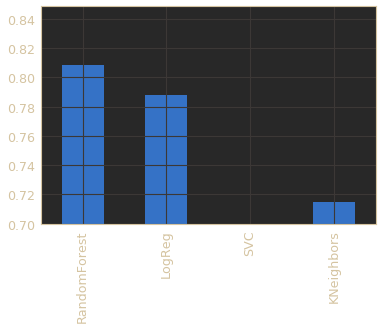

In [48]:
cv_results_df.plot(kind='bar', legend=False, ylim=0.7)

Как видно, лучше всего себя показал `RandomForest`.
Взглянем на графики ROC-кривых для оценки точности работы классификатора.
Графики нарисуем с помощью [matplotlib](http://matplotlib.org/).

<Figure size 432x288 with 0 Axes>

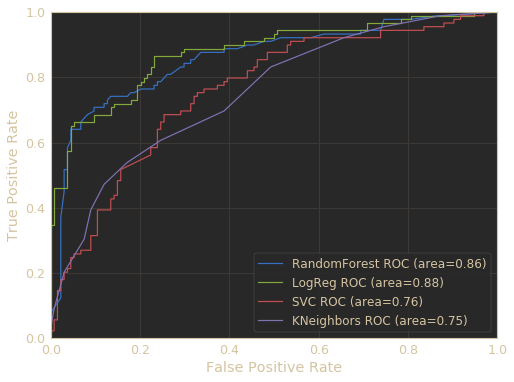

In [53]:
pl.clf()
plt.figure(figsize=(8,6))
model_svc.probability = True
for name, model in cv_models.items():
    probas = model.fit(roc_train_trn, roc_train_tgt).predict_proba(roc_test_trn)
    fpr, tpr, thresholds = roc_curve(roc_test_tgt, probas[:, 1])
    roc_auc = auc(fpr, tpr)
    pl.plot(fpr, tpr, label='{} ROC (area={:.2f})'.format(name, roc_auc))
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='large')
pl.show()

Как видно по результатам ROC-анализа, лучший результат всё же показала `LogisticRegression`.
Теперь осталось только применить нашу модель к тестовой выборке:

In [74]:
model_lr.fit(train, target)
result = pd.read_csv('test.csv')
result = pd.DataFrame(result[['PassengerId', 'Name']])
result.insert(2, 'Survived', model_lr.predict(test))
result.head(15)

,PassengerId,Name,Survived
0,892,"Kelly, Mr. James",0
1,893,"Wilkes, Mrs. James (Ellen Needs)",0
2,894,"Myles, Mr. Thomas Francis",0
3,895,"Wirz, Mr. Albert",0
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1
5,897,"Svensson, Mr. Johan Cervin",0
6,898,"Connolly, Miss. Kate",1
7,899,"Caldwell, Mr. Albert Francis",0
8,900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1
9,901,"Davies, Mr. John Samuel",0


## Заключение

Полученная модель при сабмите на Kaggle показала точность 0.77033.
В статье я больше хотел показать именно работу с инструментарием и ход исследования,
а не построение подробного алгоритма, как например в [этой серии](https://habr.com/post/165001/) статей.